First of all, this tutorial (https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78) was the biggest inspiration for my tutorial 

<h2> FINDING THE FACE IN THE IMAGE </h2>

In [5]:
import sys, os
import dlib # need to install cmake and boost'sudo apt-get install cmake'...
from skimage import io

In [6]:
face_detector = dlib.get_frontal_face_detector() #creates HOG face detector

In [7]:
# transform image to array

image = io.imread('will_ferrell.jpg')

In [8]:
# Run the HOG face detector on the image data 
# Result will be the bounding boxes of the faces in our image

detected_faces = face_detector(image, 1)


In [9]:
import cv2

# loop over detected faces

for face in detected_faces:
    x = face.left()
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y

    # draw box over face
    cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)

In [10]:
# Show image with face recognition rectangle

from matplotlib import pyplot as plt
plt.imshow(image)


<h2> FACE LANDMARK ESTIMATION </h2>

In [14]:
# You can download the required pre-trained face detection model here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = "shape_predictor_68_face_landmarks.dat" 

In [15]:
# Creates a HOG shape detector
face_pose_predictor = dlib.shape_predictor(predictor_model)

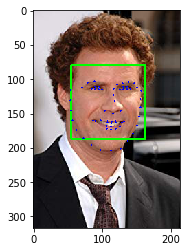

In [16]:
from imutils import face_utils

# get coordinates from shape 
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

# Loop through each face we found in the image

# Note that this loop was used before to draw the face rectangle
# Just doing this again because it's for educational purpose, so i'm doing step by step
# But we could have done the step in the loop bellow before

for i, face_rect in enumerate(detected_faces):
    
    ### Dlib shape predictor searchs for 68 distint points of a face rect
    ### (There are other models with more points - like HELEN model - but this one works just fine)
    # for more info: https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
    shape = face_pose_predictor(image, face_rect)
    shape = face_utils.shape_to_np(shape)

 
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        
plt.imshow(image)


<h2> FACE TRANSFORMATION USING LANDMARKS</h2>

<h3> Now that we found the face landmarks, we got to have the face centralized in the image for better predictions </h3>

In [17]:
# the one lib that matters
# it's really shitty to install, follow this:
##git clone https://github.com/cmusatyalab/openface.git
##cd openface
##pip install -r requirements.txt
##sudo python setup.py install
import openface

In [18]:
face_aligner = openface.AlignDlib(predictor_model)

In [19]:
# So, this loop again (no dejávu here)

# Loop through each face we found in the image
for i, face_rect in enumerate(detected_faces):

    # Use openface to calculate and perform the face alignment
    alignedFace = face_aligner.align(534, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

    # Save the aligned image to a file
    cv2.imwrite("aligned_face_{}.jpg".format(i), alignedFace)
    

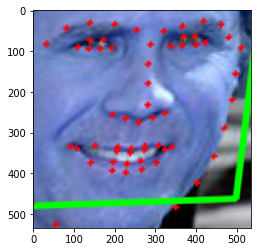

In [20]:
# Showing aligned image (just for )

aligned_img = plt.imread('aligned_face_0.jpg')
plt.imshow(aligned_img)

<h3> The image above is kinda ugly, we don't want that, so we got to rewrite some steps above for a clean and beautiful centralized image</h3>

In [27]:

# Load the image again
image = io.imread('will_ferrell.jpg')

In [29]:
# Run the HOG face detector on the image data
detected_faces = face_detector(image, 1)

print("Found {} faces in the image file {}".format(len(detected_faces), 'will_ferrell.jpg'))

# Loop through each face we found in the image
for i, face_rect in enumerate(detected_faces):

    # Get the the face's pose
    pose_landmarks = face_pose_predictor(image, face_rect)

    # Use openface to calculate and perform the face alignment
    alignedFace = face_aligner.align(534, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

    # Save the aligned image to a file
    cv2.imwrite("aligned_face_{}.jpg".format(i), alignedFace)

Found 1 faces in the image file will_ferrell.jpg


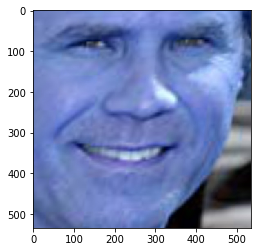

In [30]:
aligned_image = plt.imread('aligned_face_0.jpg')
plt.imshow(aligned_image)

# b e a t i f u l

<h1> THE GRAND FINALE: TELLING FACES APART </h1>

<h4> finally </h4>

In [31]:
# The face_recognition lib does everything we did above and more
# It uses the OpenFace embeddings and and SVM classifier
# BUT OpenFace is a lua script, really hard to run on jupyter 
# SO the best alternative is depend on face_recognition
import face_recognition

In [32]:
# This package can classify faces only if there are unknown faces to compare
unknown_image = plt.imread('barack.jpg')

In [33]:
try:
    will_ferrell_encoding = face_recognition.face_encodings(aligned_image)[0]
    unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]
except IndexError:
    print("I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...")
    quit()

In [34]:
known_faces = [
    will_ferrell_encoding
]

In [35]:
# results is an array of True/False telling if the unknown face matched anyone in the known_faces array
results = face_recognition.compare_faces(known_faces, unknown_face_encoding)

print("Is the unknown face a picture of Will Ferrell? {}".format(results[0]))
print("Is the unknown face a new person that we've never seen before? {}".format(not True in results))


Is the unknown face a picture of Will Ferrell? False
Is the unknown face a new person that we've never seen before? True
